vertics = 10
ver_num = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

random graph 1
edges = [(0, 2), (0, 4), (0, 6), (0, 8), (1, 3), (1, 4), (1, 5), (1, 6), (2, 5), (2, 7), (4, 8), (4, 9), (5, 6), (5, 8), (5, 9), (6, 8), (7, 8), (7, 9), (8, 9)]

random graph 2
edges = [(0, 1), (0, 3), (0, 6), (0, 7), (0, 8), (0, 9), (2, 3), (2, 4), (2, 6), (3, 7), (4, 5), (4, 7), (5, 6), (5, 8), (6, 7), (6, 8), (6, 9), (7, 9), (8, 9)]

random graph 3
edges = [(0, 1), (0, 5), (0, 6), (0, 8), (0, 9), (1, 3), (1, 5), (1, 7), (1, 8), (2, 3), (2, 6), (2, 7), (2, 9), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (4, 5), (4, 6), (4, 7), (4, 9), (5, 6), (6, 7), (6, 9), (7, 8), (8, 9)]

random graph 4
edges = [(0, 5), (0, 6), (0, 8), (1, 3), (1, 4), (1, 5), (1, 7), (1, 8), (2, 4), (2, 7), (2, 8), (3, 4), (3, 5), (3, 8), (4, 6), (5, 7), (7, 8), (7, 9), (8, 9)]

random graph 5
edges = [(0, 3), (0, 5), (0, 9), (1, 2), (1, 4), (1, 7), (2, 3), (2, 4), (2, 5), (2, 7), (2, 9), (3, 4), (3, 6), (4, 5), (4, 6), (4, 8), (4, 9), (6, 7), (6, 9

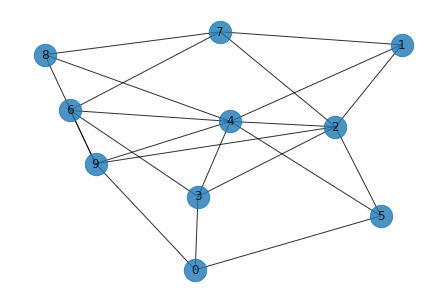

In [1]:
import warnings
warnings.simplefilter(action='ignore',)

from qiskit import QuantumCircuit, Aer
from qiskit.circuit import ParameterVector
from qiskit.visualization import plot_histogram


from time import time
import networkx as nx

n = 10
r = 4

iter = 5
print("vertics = " + str(n))
print("ver_num = " + str([i for i in range(n)]))

value_dc_qaoa_ls = []
ubound_sdp_ls = []
for i in range(iter):
    print("\nrandom graph " + str(i+1))

    G = nx.erdos_renyi_graph(n, 0.1, 100 * i, directed=False)
    while nx.is_connected(G) == False:
        G = nx.erdos_renyi_graph(n, 0.5, directed=False)
    print("edges = " + str(list(G.edges)))
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

In [2]:
def create_circ(theta, n, repeat):
    
    nqubits = n 
    qc = QuantumCircuit(nqubits)
    
    r = repeat
    t = 0
    
    for i in range(r):   
        for j in range(nqubits // 2):
            qc.ry(theta[t+2*j], j)
            qc.rz(theta[t+2*j+1], j)

        if i < r-1: 
            for j in range(nqubits // 2-1):
                qc.cnot(j, (j+1))
            qc.cnot(nqubits//2-1, 0)
        t += nqubits

    t = int(len(theta)/2)
    for i in range(r):   
        for j in range(nqubits // 2):
            qc.ry(theta[t+2*j], j+nqubits//2)
            qc.rz(theta[t+2*j+1], j+nqubits//2)
        if i < r-1: 
            for j in range(nqubits//2, nqubits-1):
                qc.cnot(j, j+1)
            qc.cnot(nqubits-1, nqubits//2)
        t += nqubits
    
    qc.measure_all()
    return qc

In [3]:
def maxcut_obj(x, G):
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj

def compute_expectation(counts, G):
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

def get_expectation(G, r, shots=1024):
     
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_circ(theta, n, r)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=1024).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

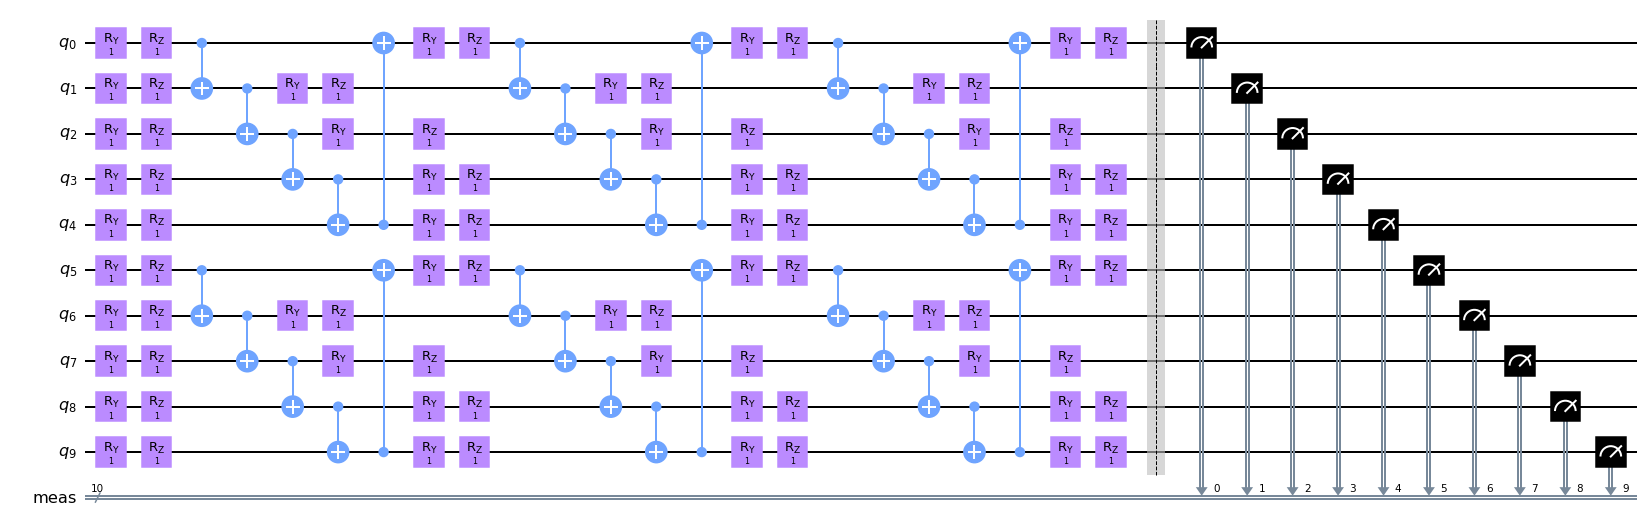

In [4]:
para = []
for i in range(r*2*n): para.append(1.0)
create_circ(para, n, r).draw(output="mpl", fold=-1)

In [5]:
from scipy.optimize import minimize

start = time()
expectation = get_expectation(G, r)
res = minimize(expectation, 
               para, 
               method='COBYLA')
end = time()
print("Cost time:",end-start)
# print(res)

Cost time: 8.850142002105713


In [6]:
backend = Aer.get_backend('qasm_simulator')
backend.shots = 1024

qc_res = create_circ(res.x, n, r)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
sort = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
print("Top 4 solutions:")
es = 0
for i in sort:
    print('sol:',i,', max cut:', -maxcut_obj(i,G))
    es+=1
    if es == 4: break
# plot_histogram(counts)

expect = []
for i in range(100): expect.append(nx.algorithms.approximation.maxcut.one_exchange(G)[0])
print('\nexpect max cut:', max(expect))

Top 4 solutions:
sol: 1010101010 , max cut: 17
sol: 1110001010 , max cut: 17
sol: 1010001010 , max cut: 16
sol: 1010100110 , max cut: 15

expect max cut: 17


#### Parameterized $U_1$

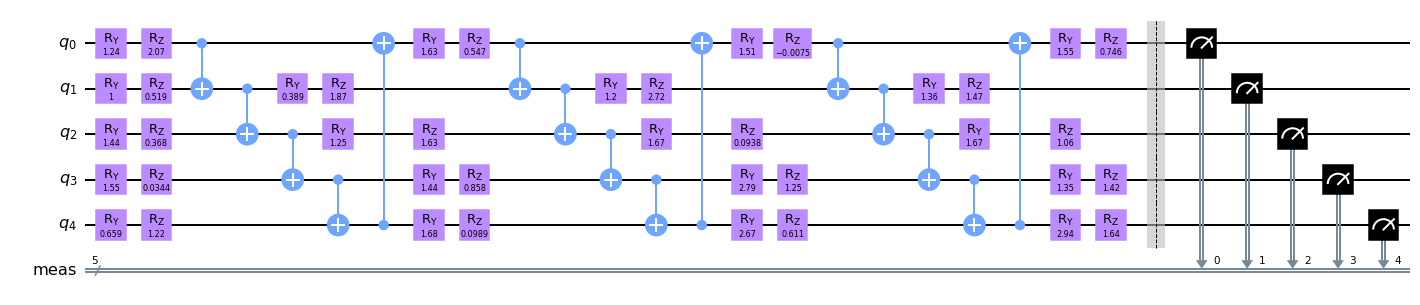

In [7]:
qc_u1 = QuantumCircuit(int(n/2))
pv_u1 = ParameterVector('p_1', n*r)

t = 0
for i in range(r):
    for j in range(n // 2):
        qc_u1.ry(res.x[t+2*j], j)
        qc_u1.rz(res.x[t+2*j+1], j)
        
    if i < r-1: 
        for j in range(n // 2-1):
            qc_u1.cnot(j, (j+1))
        qc_u1.cnot(n//2-1, 0)
    t += n

qc_u1.measure_all()
qc_u1.draw(output="mpl", fold=-1)

Top 4 measurement:
meas: 01010
meas: 00110
meas: 10110
meas: 01000


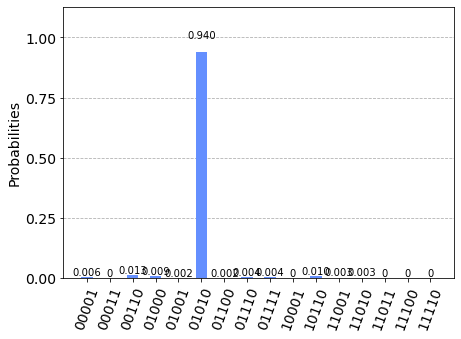

In [8]:
result = backend.run(qc_u1, seed_simulator=10).result()
counts = result.get_counts()

sort = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
print("Top 4 measurement:")
es = 0
for i in sort:
    print('meas:',i)
    es+=1
    if es == 4: break
plot_histogram(counts)

#### Parameterized $U_2$

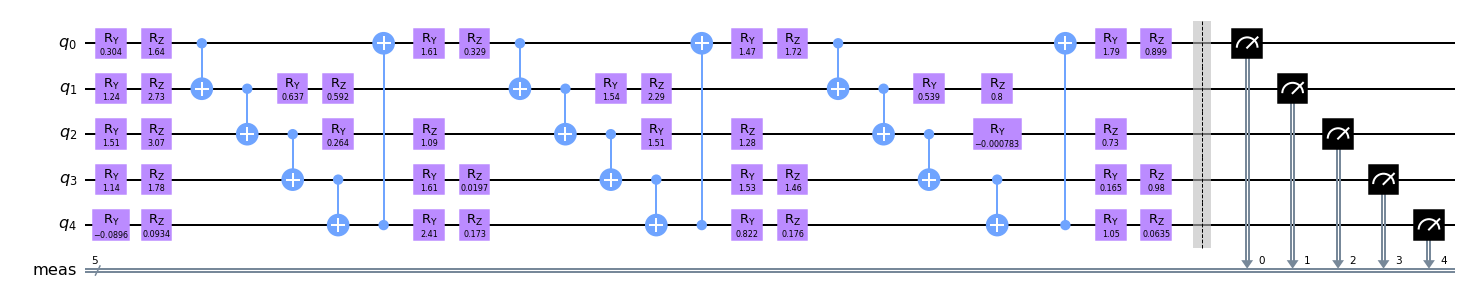

In [9]:
qc_u2 = QuantumCircuit(int(n/2))
pv_u2 = ParameterVector('p_2', n*r)

    
t = int(len(res.x)/2)
for i in range(r):   
    for j in range(n // 2):
        qc_u2.ry(res.x[t+2*j], j)
        qc_u2.rz(res.x[t+2*j+1], j)
        
    if i < r-1: 
        for j in range(n // 2-1):
            qc_u2.cnot(j, (j+1))
        qc_u2.cnot(n//2-1, 0)
    t += n
   
qc_u2.measure_all()
qc_u2.draw(output="mpl",fold=-1)

Top 4 measurement:
meas: 10101
meas: 11100
meas: 10100
meas: 11101


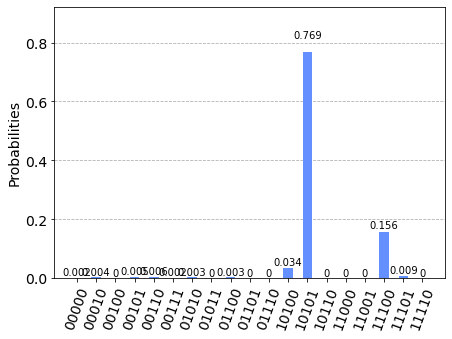

In [10]:
result = backend.run(qc_u2, seed_simulator=10).result()
counts = result.get_counts()

sort = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
print("Top 4 measurement:")
es = 0
for i in sort:
    print('meas:',i)
    es+=1
    if es == 4: break
plot_histogram(counts)